In [1]:
# Importanweisungen

import numpy as np
import statistics as stat
import scipy as sci
import sympy as sym
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.axes as axes
from matplotlib import colors as mcolors
import math
from scipy import optimize
import uncertainties as unc
import uncertainties.unumpy as unp 
import uncertainties.umath as umath
unv=unp.nominal_values
usd=unp.std_devs

In [2]:
# Konstanten fuer einheitliche Darstellung

fig_size = (10, 6)
fig_legendsize = 14
fig_labelsize = 12
matplotlib.rcParams.update({'font.size': fig_labelsize})

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
#colors

In [3]:
# mathe Funktionen

def mean(n):
    # find the mean value and add uncertainties
    k = np.mean(n)
    err = stat.variance(unv(n))
    return unc.ufloat(unv(k), math.sqrt(usd(k)**2 + err))

In [4]:
# allgemeine Fitfunktionen

def linear(x,m): # lineare Funktion mit f(x) = m * x 
    return(m*x)

def gerade(x, m, b): # gerade mit = f(x) = m * x + b
    return (m*x + b)

def cyclic(x, a, f, phi):
    return a * np.sin(x * f - phi)

def cyclicOff(x, a, f, phi, offset):
    return cyclic(x, a, f, phi) + offset

def gauss(x, x0, A, d, y0):
    return A * np.exp(-(x - x0)**2 / 2 / d**2) + y0

def exponential(x, c, y0):
    return np.exp(c * x) * y0

# fittet ein dataset mit gegebenen x und y werten, eine funktion und ggf. anfangswerten und y-Fehler
# gibt die passenden parameter der funktion, sowie dessen unsicherheiten zurueck
#
# https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i#
# Updated on 4/6/2016
# User: https://stackoverflow.com/users/1476240/pedro-m-duarte
def fit_curvefit(datax, datay, function, p0=None, yerr=None, **kwargs):
    pfit, pcov = \
         optimize.curve_fit(function,datax,datay,p0=p0,\
                            sigma=yerr, epsfcn=0.0001, **kwargs)
    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_curvefit = pfit
    perr_curvefit = np.array(error)
    return pfit_curvefit, perr_curvefit 

# usage zB:
# pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [1, 0])
# fuer eine gerade mit anfangswerten m = 1, b = 0

In [5]:
# gibt Daten fuer LaTeX bereitgestellt aus

def latex_printValue(val, file):
    if hasattr(val, "__iter__"):
        i = 1
        for v in val:
            latex_printValue(v, file+"_"+str(i))
            i += 1
    else:
        f = open('data/%s.txt' % file, 'w')
        f.write(str(val).replace('/', ''))
        f.close()

In [6]:
# weitere Werte, Konstanten
# Werte von https://physics.nist.gov/cuu/Constants/index.html[0]

c = 299792458 # m/s
k_B = unc.ufloat_fromstr("1.38064852(79)e-23") # J K-1 [0]
h = unc.ufloat_fromstr("4.135667662(25)e-15") # eV s [0]
r_e = unc.ufloat_fromstr("2.8179403227(19)e-15") # m [0]
R = unc.ufloat_fromstr("8.3144598(48)") # J mol-1 K-1 [0]
K = 273.15 # kelvin 
g = 9.81 # m/s^2
rad = 360 / 2 / math.pi
grad = 1/rad

In [7]:
# import der messwerte

unc_winkel = 1/60 / 2 / np.sqrt(6) # analog bemessener winkel an noniusskala
unc_LED = 30 * unc_winkel # analog ungefaehr abgelesener wert
unc_gitter = 0 * 1 / 300 / 2 / np.sqrt(3) # schaetzung der genauigkeit der gitter
unc_spannung = 0.01 / 2 / np.sqrt(3) # digital Spannung

def converter(data):
    try:
        return float(s if len(s) > 0 else 0)
    except:
        return data
        
con = {}
for i in range(50):
    con[i] = converter
    
g1 = unc.ufloat(1/300000, unc_gitter) # 1/300 mm
g2 = unc.ufloat(1/600000, unc_gitter/2) # 1/600 mm
    
data = np.loadtxt("messung/gitter1.csv", skiprows = 2, delimiter = ",")
gitter1 = (unp.uarray(data[1:,0], 0), unp.uarray(data[1:,1], unc_winkel), unp.uarray(data[1:,2], unc_winkel))

data = np.loadtxt("messung/gitter2.csv", skiprows = 2, delimiter = ",")
gitter2 = (unp.uarray(data[1:,0], 0), unp.uarray(data[1:,1], unc_winkel), unp.uarray(data[1:,2], unc_winkel))

data = np.loadtxt("messung/he.csv", skiprows = 2, delimiter = ",")
he = unp.uarray(data[:], unc_winkel)

data = np.loadtxt("messung/energiespar.csv", skiprows = 2, delimiter = ",")
energiespar = unp.uarray(data[:], unc_winkel)

data = np.loadtxt("messung/AngabeHe.csv", skiprows = 2, delimiter = ",")
heAngabe = unp.uarray(data[:], 0)

data = np.loadtxt("messung/dioden.csv", skiprows = 2, delimiter = ",")
dioden = (unp.uarray([np.mean(n) for n in data[:, 0:3]], unc_spannung), unp.uarray(data[:,3], unc_LED))

In [8]:
# Rechnung he

xdata, ydata = unp.sin(he * grad), heAngabe[:4:-1]

pfit, perr = fit_curvefit(unv(xdata), unv(ydata), linear, p0 = [1])
gConst = unp.uarray(pfit, perr)
g2 = gConst
latex_printValue(gConst, "GitterKonstante2_m-1")
latex_printValue(1/gConst/1000, "GitterKonstante2_1nm")

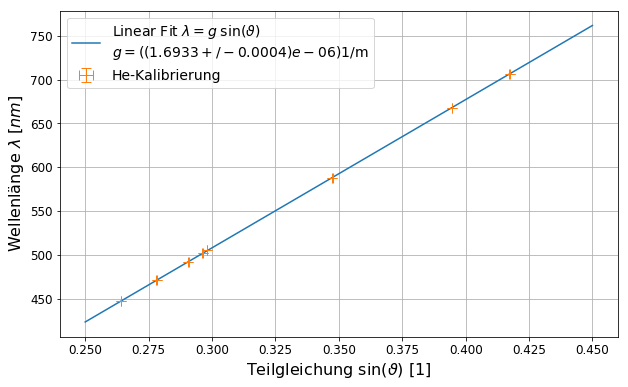

In [9]:
# Diagramm he gitter pruefung

fig=plt.figure(figsize=fig_size)
#ax = plt.gca()
#color = next(ax._get_lines.prop_cycler)['color']

xdata = np.linspace(0.25, 0.45)
plt.plot(xdata, unv(linear(xdata, *gConst)*1e9), label='Linear Fit $\\lambda=g\\; \\sin(\\vartheta)$\n$g = (%s)$1/m' % tuple(gConst))

xdata, ydata = unp.sin(he * grad), heAngabe[:4:-1]*1e9
plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=1, label='He-Kalibrierung')

# plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Teilgleichung $\\sin(\\vartheta)$ [$1$]", {'fontsize':fig_legendsize+2})
plt.ylabel("Wellenlänge $\\lambda$ [$nm$]", {'fontsize': fig_legendsize+2})
#plt.yticks([])
plt.savefig("data/GitterConstPruef.pdf")
plt.show()

In [10]:
# Rechnung gitter1

ordnung, gelb1, gelb2 = gitter1
lambda1 = (ordnung, g1 / ordnung * unp.sin(gelb1 * grad), g1 / ordnung * unp.sin(gelb2 * grad))

#pfit, perr = fit_curvefit(unv(xdata), unv(ydata), linear, yerr = usd(ydata), p0 = [1])
#magnet = unp.uarray(pfit, perr)

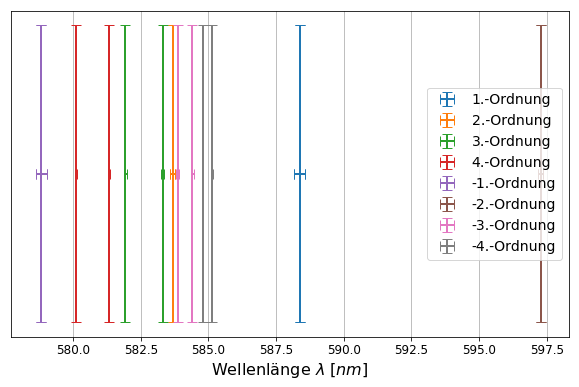

In [11]:
# Diagramm gitter1

fig=plt.figure(figsize=fig_size)
ax = plt.gca()
#color = next(ax._get_lines.prop_cycler)['color']

ordnung, lamb1, lamb2 = lambda1

#xdata = np.linspace(-1.1, 1.1)
#plt.plot(xdata, unv(linear(xdata, *magnet)), label='Linear Fit $B=m I$\n$m = (%s)$mT/A' % tuple(magnet))

#colorCycle = [colors['y'], colors['wheat'], colors['r'], colors['red'], 'b', 'blue', 'g', 'green']
#ax.set_prop_cycle('color', colorCycle)
for (o, x1, x2) in [(ordnung[i], lamb1[i], lamb2[i]) for i in range(len(lamb1))]:
    color = next(ax._get_lines.prop_cycler)['color']
    xdata, ydata = np.array([x1,x2])*1e9, unp.uarray([0.5]*2, 0.5)
    plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=2, color = color, label='%i.-Ordnung' % int(unv(o)))
    
#color = next(ax._get_lines.prop_cycler)['color']
#xdata, ydata = lamb1, unp.uarray([0.5]*8, 0.5)
#plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=2, color=colors['y'], label='Na-D-Linie 1')

#xdata, ydata = lamb2, unp.uarray([0.5]*8, 0.5)
#plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=1, color='yellow', label='Na-D-Linie 2')

# plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Wellenlänge $\\lambda$ [$nm$]", {'fontsize':fig_legendsize+2})
#plt.ylabel("Magnetfeldstärke $B$ [$mT$]", {'fontsize': fig_legendsize+2})
plt.yticks([])
plt.savefig("data/Gitter300.pdf")
plt.show()

In [12]:
# Rechnung gitter2

ordnung, gelb1, gelb2 = gitter2
lambda2 = (ordnung, g2 / ordnung * unp.sin(gelb1 * grad), g2 / ordnung * unp.sin(gelb2 * grad))

#pfit, perr = fit_curvefit(unv(xdata), unv(ydata), linear, yerr = usd(ydata), p0 = [1])
#magnet = unp.uarray(pfit, perr)

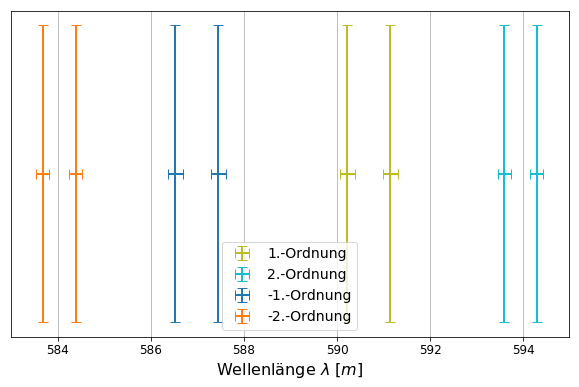

In [13]:
# Diagramm gitter2

fig=plt.figure(figsize=fig_size)
#ax = plt.gca()
#color = next(ax._get_lines.prop_cycler)['color']

ordnung, lamb1, lamb2 = lambda2

#xdata = np.linspace(-1.1, 1.1)
#plt.plot(xdata, unv(linear(xdata, *magnet)), label='Linear Fit $B=m I$\n$m = (%s)$mT/A' % tuple(magnet))

for (o, x1, x2) in [(ordnung[i], lamb1[i], lamb2[i]) for i in range(len(lamb1))]:
    color = next(ax._get_lines.prop_cycler)['color']
    xdata, ydata = np.array([x1,x2])*1e9, unp.uarray([0.5]*2, 0.5)
    plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=2, color = color, label='%i.-Ordnung' % int(unv(o)))

#xdata, ydata = lamb1, unp.uarray([0.5]*4, 0.5)
#plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=2, color='yellow', label='Na-D-Linie 1')

#xdata, ydata = lamb2, unp.uarray([0.5]*4, 0.5)
#plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=1, color='orange', label='Na-D-Linie 2')

# plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Wellenlänge $\\lambda$ [$m$]", {'fontsize':fig_legendsize+2})
#plt.ylabel("Magnetfeldstärke $B$ [$mT$]", {'fontsize': fig_legendsize+2})
plt.yticks([])
plt.savefig("data/Gitter600.pdf")
plt.show()

In [14]:
# Rechnung he, energiespar

hespar = (g2 * unp.sin(he * grad), g2 * unp.sin(energiespar * grad))

#pfit, perr = fit_curvefit(unv(xdata), unv(ydata), linear, yerr = usd(ydata), p0 = [1])
#magnet = unp.uarray(pfit, perr)
latex_printValue(hespar[1]*1e9, "EnergieSparWellen_nm")

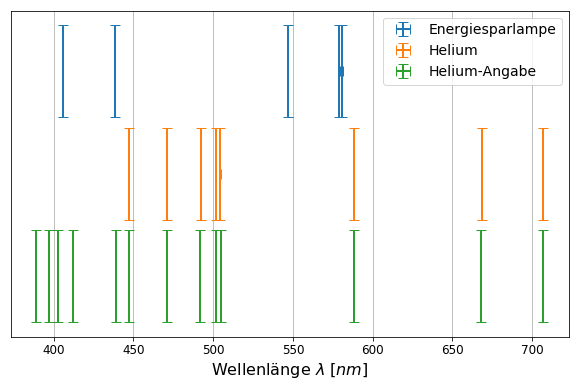

In [15]:
# Diagramm he, energiespar vergleich

fig=plt.figure(figsize=fig_size)
#ax = plt.gca()
#color = next(ax._get_lines.prop_cycler)['color']

h, s = hespar

#xdata = np.linspace(-1.1, 1.1)
#plt.plot(xdata, unv(linear(xdata, *magnet)), label='Linear Fit $B=m I$\n$m = (%s)$mT/A' % tuple(magnet))

xdata, ydata = s*1e9, unp.uarray([1.5]*len(s), 0.45)
plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=2, label='Energiesparlampe')

xdata, ydata = h*1e9, unp.uarray([0.5]*len(h), 0.45)
plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=2, label='Helium')

xdata, ydata = heAngabe*1e9, unp.uarray([-0.5]*len(heAngabe), 0.45)
plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=2, label='Helium-Angabe')

# plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Wellenlänge $\\lambda$ [$nm$]", {'fontsize':fig_legendsize+2})
#plt.ylabel("Magnetfeldstärke $B$ [$mT$]", {'fontsize': fig_legendsize+2})
plt.yticks([])
plt.savefig("data/EnergieSpar.pdf")
plt.show()

In [16]:
# Rechnung dioden

lamb = g2 * unp.sin(dioden[1])
xdata, ydata = 1/lamb, dioden[0]

pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, p0 = [1, 0])
hc = unp.uarray(pfit, perr)

latex_printValue(hc[0], "hc")

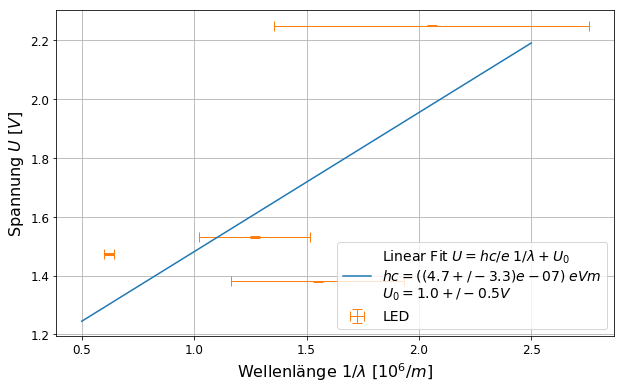

In [17]:
# Diagramm dioden

fig=plt.figure(figsize=fig_size)
#ax = plt.gca()
#color = next(ax._get_lines.prop_cycler)['color']

xdata = np.linspace(0.5e6, 2.5e6)
plt.plot(xdata/1e6, unv(gerade(xdata, *hc)), label='Linear Fit $U=hc/e\\; 1/\\lambda + U_0$\n$hc = (%s)\\;eVm$\n$U_0 = %s V$' % tuple(hc))

xdata, ydata = 1/lamb/1e6, dioden[0]
plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=1, label='LED')

# plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Wellenlänge $1/\\lambda$ [$10^6/m$]", {'fontsize': fig_legendsize+2})
plt.ylabel("Spannung $U$ [$V$]", {'fontsize':fig_legendsize+2})
#plt.yticks([])
plt.savefig("data/Dioden.pdf")
plt.show()

In [18]:
# Rechnung Mikroskopaufloesung

# A = lambda / lambda_min = m N = m l/g2